In [302]:
import os, sys, csv
import essentia
from essentia import *
from essentia.standard import *
from pylab import *
from numpy import *
import matplotlib.pyplot as plt
import numpy as np
import scipy
import librosa
import librosa.display
import pandas as pd
import glob
import pickle

# Parameters

In [303]:

hopSize = 128
frameSize = 2048
sampleRate = 44100
guessUnvoiced = True

median_filter_size = 21
block_chromagram = 150
ref_note_hz = 55.0

notes = librosa.hz_to_note([55.0,58.27,61.74,65.41,69.30,73.42,77.78,82.41,87.31,92.50,97.99,103.83])

## Directories

In [304]:
ref_path = "/Users/dirceusilva/OneDrive/Dissertação/Dataset/MTG-QBH/audios_originais"
query_path = "/Users/dirceusilva/OneDrive/Dissertação/Dataset/MTG-QBH/audio"
metadata_path = "/Users/dirceusilva/OneDrive/Dissertação/Dataset/MTG-QBH/metadata/Queries.csv"
results_path = "/Users/dirceusilva/Documentos/tests/qbh"

# Functions

## Read Audio

In [305]:
def read_audio_essentia(filename, sampleRate):
    # create an audio loader and import audio file
    loader = essentia.standard.MonoLoader(filename = filename, sampleRate = sampleRate, downmix="mix")
    audio = loader()
    
    
    return audio, sampleRate

def read_audio_librosa(filename, sampleRate):
    # create an audio loader and import audio file
    audio, fs = librosa.load(filename, sr = sampleRate, mono=True)
    
    return audio, fs


## Melody Extraction

In [306]:
def melody_extraction(audio, framesize, hopsize):
    # PitchMelodia takes the entire audio signal as input - no frame-wise processing is required here...
    audio = EqualLoudness()(audio)
    pExt = PredominantPitchMelodia(frameSize = framesize, 
                                   hopSize = hopsize,
                                   maxFrequency = 20000.0,
                                   minFrequency = 80.0,
                                   magnitudeThreshold = 40,
                                   guessUnvoiced = False)
    pitch, pitchConf = pExt(audio)
    time=np.linspace(0.0,len(audio)/sampleRate,len(pitch) )
    
    return pitch, pitchConf, time

##  Scales Conversions

In [307]:
def hz_to_cents(hz, fref=440.0):
    m = np.asanyarray(hz)/fref
    return 1200*(np.log2(m, out=np.zeros_like(m), where=(m!=0.))) # - np.log2(fref))

def cents_to_hz(cents, fref=440.0):
    return fref * 2**(np.asanyarray(cents)/1200)

def hz_to_idx_semitone(hz, fref=440.0, pcpsize=12.0):
    m = np.asanyarray(hz)/fref
    return np.round(pcpsize*(np.log2(m, out=np.zeros_like(m), where=(m!=0.)))) % pcpsize + 1

def semitone_dist_to_hz(semitone, fref=440.0, pcpsize=12):
    return fref * 2**(np.asanyarray(semitone)/pcpsize)

def hz_to_octs(hz, tuning=0.0, pcpsize=12, fref=440.0):
    A440 = fref * 2.0 ** (tuning / pcpsize-4)
    m = np.asanyarray(hz)/float(A440)
    return np.log2(m, out=np.zeros_like(m), where=(m!=0.))

def octs_to_hz(octs, tuning=0.0, pcpsize=12, fref=440.0):
    A440 = fref * 2.0 ** (tuning / pcpsize-4)
    return float(A440) * (2.0 ** np.asanyarray(octs))

def midi_to_hz(p):
    return 440.0 * (2.0 ** ((np.asanyarray(p) - 69.0) / 12.0))

def hz_to_midi(hz, A440=440.0):
    m = np.asanyarray(hz)/float(A440)
    return 12 * np.log2(m, out=np.zeros_like(m), where=(m!=0.)) + 69

## Semitone Quantization

In [308]:
def quantization_semitone(pitch_cents):
    
    freqs=np.arange(-0.5,76,1)
    semitones=semitone_dist_to_hz(freqs,fref=ref_note_hz)
    bins_cents=hz_to_cents(semitones, fref=ref_note_hz)

    idx = np.digitize(pitch_cents, bins=bins_cents)
    cents_q = (bins_cents[idx]+bins_cents[idx-1])/2
    cents_q[cents_q < 1.0]  = 0.0

    return cents_q

## Semitones to Octaves and Chromagram

In [309]:
def semitone_to_octave(cents, pitchConf):
    
    semitones_q = np.zeros_like(cents)
    chromagram = np.zeros((12, len(cents)))

    for i in range(len(cents)):
        if cents[i] > 1.0:
            semitones_q[i] = (cents[i] / 100) % 12
            chromagram[int(semitones_q[i]),i] = pitchConf[i]
            
    return semitones_q, chromagram

## Chromagram Reduction

In [310]:
def chromagram_reduction(chromagram, block, time=None):
    
    nframes = int(np.ceil(chromagram.shape[1]/block))

    chromagram_reduced = np.zeros((chromagram.shape[0],nframes))
    
    time_reduced = None
    if time is not None:
        time_reduced = np.zeros((nframes,))

    for k in range(chromagram_reduced.shape[1]):
        start = k*block
        end = min((k+1)*block,chromagram.shape[1])
        chromagram_reduced[:,k] =  np.sum(chromagram[:,start:end], axis=1)
        if time is not None:
            time_reduced[k] = np.mean(time[start:end])
    
    # divide by max each column
    #chromagram_reduced = chromagram_reduced/(np.max(chromagram_reduced,axis=0)+np.spacing(0)) 
    
    return chromagram_reduced, time_reduced

##  Plot Chromagram

In [311]:
def plot_chromagram(chroma, times, notes, mappable = None):
    plt.figure(figsize=(20,8))
    plt_spec = plt.imshow(chroma,origin='lower', aspect="auto")

    ## create ylim
    ks      = np.arange(12)
    plt.yticks(ks,notes)
    plt.ylabel("Notes")

    ## create xlim
    Nxticks = 10
    ts_spec = np.linspace(0,chroma.shape[1],Nxticks)

    ts_spec_sec  = ["{:4.2f}".format(times[min(int(i),len(times)-1)]) for i in ts_spec]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title("Chromagram")
    plt.colorbar(mappable,use_gridspec=True)
    plt.show()
    return(plt_spec)

## Chromagram Extraction Algorithm

In [312]:
def chromagram_extraction(audio, frameSize, hopSize):
    # Melody Extraction
    pitch, pitchConf, time = melody_extraction(audio, frameSize, hopSize)
    # Convert to cents
    pitch_cents = hz_to_cents(pitch, fref=ref_note_hz)
    # Quantization
    pitch_cents_q = quantization_semitone(pitch_cents)
    # Median Filter
    pitch_cents_q_filtered=scipy.signal.medfilt(pitch_cents_q, median_filter_size)
    # Chromagram
    pitch_semitones_q, chromagram = semitone_to_octave(pitch_cents_q_filtered, pitchConf)
    # Chromagram reduction
    chromagram_reduced, time_reduced = chromagram_reduction(chromagram, block_chromagram, time=time)
    
    return chromagram_reduced, time_reduced

# Algorithm

## Load and Extract Reference Dataset

In [313]:

filenames = glob.glob(os.path.join(ref_path,"*.wav"))

ref_melody = []
ref_dic = {}

for k,filepath in enumerate(filenames):
    file = os.path.basename(filepath)[:-4]
    print("{:d} - {:d} - {}".format(k, len(filenames), file))

    ref_dic[file] = {}
    ref_dic[file]["songid"] = file
    
    audio, fs = read_audio_essentia(filepath, sampleRate)
    chromagram_reduced, time_reduced = chromagram_extraction(audio, frameSize, hopSize)
    
    ref_dic[file]["chroma"] = chromagram_reduced.T.astype(np.float32)
    ref_dic[file]["time"] = time_reduced
    


0 - 81 - 2015
1 - 81 - 1252
2 - 81 - 1118
3 - 81 - 1441
4 - 81 - 937
5 - 81 - 276
6 - 81 - 14
7 - 81 - 663
8 - 81 - 1719
9 - 81 - 1849
10 - 81 - 941
11 - 81 - 1806
12 - 81 - 1185
13 - 81 - 60
14 - 81 - 1224
15 - 81 - 2063
16 - 81 - 1568
17 - 81 - 995
18 - 81 - 2115
19 - 81 - 2074
20 - 81 - 1794
21 - 81 - 1747
22 - 81 - 204
23 - 81 - 1237
24 - 81 - 1579
25 - 81 - 1592
26 - 81 - 98
27 - 81 - 1168
28 - 81 - 1546
29 - 81 - 2113
30 - 81 - 70
31 - 81 - 1142
32 - 81 - 1194
33 - 81 - 1396
34 - 81 - 1209
35 - 81 - 789
36 - 81 - 1786
37 - 81 - 2269
38 - 81 - 1576
39 - 81 - 814
40 - 81 - 1832
41 - 81 - 96
42 - 81 - 2056
43 - 81 - 593
44 - 81 - 1616
45 - 81 - 1564
46 - 81 - 2045
47 - 81 - 2086
48 - 81 - 1438
49 - 81 - 1835
50 - 81 - 1808
51 - 81 - 1175
52 - 81 - 1411
53 - 81 - 768
54 - 81 - 542
55 - 81 - 597
56 - 81 - 965
57 - 81 - 391
58 - 81 - 2133
59 - 81 - 2090
60 - 81 - 780
61 - 81 - 1139
62 - 81 - 1066
63 - 81 - 479
64 - 81 - 646
65 - 81 - 1488
66 - 81 - 2208
67 - 81 - 281
68 - 81 - 2026
69 

In [314]:
fileRef = "ChromaRef.pkl"

with open(os.path.join(results_path, fileRef),"wb") as f:
    pickle.dump(ref_dic,f)

## Load Metadata

In [315]:
Queries_df = pd.read_csv(metadata_path, sep=",")
songid = Queries_df[Queries_df["Query ID"] == "q1"]["Song ID"].values.astype(str)[0]
print(songid)

1118


## Load and Extract Query Dataset

In [316]:
filenames = glob.glob(os.path.join(query_path,"*.wav"))

query_dic = {}

for k,filepath in enumerate(filenames):
    file = os.path.basename(filepath)[:-4]
    print("{:d} - {:d} - {}".format(k, len(filenames), file))
    query = file.split(".")[0]
    query_dic[file] = {}
    query_dic[file]["query"] = query
    query_dic[file]["songid"] = Queries_df[Queries_df["Query ID"] == file]["Song ID"].values.astype(str)[0]
    
    audio, fs = read_audio_essentia(filepath, sampleRate)
    chromagram_reduced, time_reduced = chromagram_extraction(audio, frameSize, hopSize)
    
    query_dic[file]["chroma"] = chromagram_reduced.T.astype(np.float32)
    query_dic[file]["time"] = time_reduced
    

0 - 118 - q13
1 - 118 - q12
2 - 118 - q10
3 - 118 - q38
4 - 118 - q39
5 - 118 - q11
6 - 118 - q29
7 - 118 - q15
8 - 118 - q14
9 - 118 - q28
10 - 118 - q16
11 - 118 - q9
12 - 118 - q8
13 - 118 - q17
14 - 118 - q70
15 - 118 - q64
16 - 118 - q58
17 - 118 - q59
18 - 118 - q65
19 - 118 - q71
20 - 118 - q118
21 - 118 - q67
22 - 118 - q73
23 - 118 - q98
24 - 118 - q99
25 - 118 - q72
26 - 118 - q66
27 - 118 - q62
28 - 118 - q76
29 - 118 - q89
30 - 118 - q88
31 - 118 - q77
32 - 118 - q63
33 - 118 - q108
34 - 118 - q49
35 - 118 - q75
36 - 118 - q61
37 - 118 - q60
38 - 118 - q74
39 - 118 - q48
40 - 118 - q109
41 - 118 - q104
42 - 118 - q110
43 - 118 - q51
44 - 118 - q45
45 - 118 - q79
46 - 118 - q92
47 - 118 - q86
48 - 118 - q87
49 - 118 - q93
50 - 118 - q78
51 - 118 - q44
52 - 118 - q50
53 - 118 - q111
54 - 118 - q105
55 - 118 - q113
56 - 118 - q107
57 - 118 - q46
58 - 118 - q52
59 - 118 - q85
60 - 118 - q91
61 - 118 - q90
62 - 118 - q84
63 - 118 - q53
64 - 118 - q47
65 - 118 - q106
66 - 118 - q

In [317]:
fileQuery = "ChromaQuery.pkl"

with open(os.path.join(results_path, fileQuery),"wb") as f:
    pickle.dump(query_dic,f)

## Read Chromas

In [318]:
fileQuery = "ChromaQuery.pkl"

with open(os.path.join(results_path, fileQuery),"rb") as f:
    query_dic = pickle.load(f)

fileRef = "ChromaRef.pkl"

with open(os.path.join(results_path, fileRef),"rb") as f:
    ref_dic = pickle.load(f)

## Comparisons

In [319]:
pChromaCrossSim = ChromaCrossSimilarity(frameStackSize=1)
pCoverSongSim = CoverSongSimilarity(alignmentType="serra09")

results = {}

for k,q in enumerate(query_dic.keys()):
    print("{:d} - {:d} - {}".format(k, len(query_dic), query_dic[q]["query"]))
    
    results[q] = {"query": query_dic[q]["query"],
                  "songid": query_dic[q]["songid"],
                  "res": []}
    
    for r in ref_dic.keys():

        csm = pChromaCrossSim(query_dic[q]["chroma"], ref_dic[r]["chroma"])
        scoreMatrix, distance = pCoverSongSim(csm)
        
        res = {}
        res["scoreMatrix"] = scoreMatrix
        res["distance"] = distance
        res["csm"] = csm
        res["ref"] = r
        
        results[q]["res"].append(res)

        

fileResults = "Results.pkl"

with open(os.path.join(results_path, fileResults),"wb") as f:
    pickle.dump(results,f)

0 - 118 - q13
1 - 118 - q12
2 - 118 - q10
3 - 118 - q38
4 - 118 - q39
5 - 118 - q11
6 - 118 - q29
7 - 118 - q15
8 - 118 - q14
9 - 118 - q28
10 - 118 - q16
11 - 118 - q9
12 - 118 - q8
13 - 118 - q17
14 - 118 - q70
15 - 118 - q64
16 - 118 - q58
17 - 118 - q59
18 - 118 - q65
19 - 118 - q71
20 - 118 - q118
21 - 118 - q67
22 - 118 - q73
23 - 118 - q98
24 - 118 - q99
25 - 118 - q72
26 - 118 - q66
27 - 118 - q62
28 - 118 - q76
29 - 118 - q89
30 - 118 - q88
31 - 118 - q77
32 - 118 - q63
33 - 118 - q108
34 - 118 - q49
35 - 118 - q75
36 - 118 - q61
37 - 118 - q60
38 - 118 - q74
39 - 118 - q48
40 - 118 - q109
41 - 118 - q104
42 - 118 - q110
43 - 118 - q51
44 - 118 - q45
45 - 118 - q79
46 - 118 - q92
47 - 118 - q86
48 - 118 - q87
49 - 118 - q93
50 - 118 - q78
51 - 118 - q44
52 - 118 - q50
53 - 118 - q111
54 - 118 - q105
55 - 118 - q113
56 - 118 - q107
57 - 118 - q46
58 - 118 - q52
59 - 118 - q85
60 - 118 - q91
61 - 118 - q90
62 - 118 - q84
63 - 118 - q53
64 - 118 - q47
65 - 118 - q106
66 - 118 - q

## results ordered by distances

In [320]:

def distSort(elem):
    return elem["distance"]

for q in results:
    results[q]["res"].sort(key=distSort)
    

## Analysis

In [321]:
covers = []
ncovers = []

for query in results:
    
    print(query)
    
    for k, ref in enumerate(results[query]["res"]):
        if ref_dic[ref["ref"]]["songid"] == query_dic[query]["songid"]:
            covers.append(ref["distance"])
        else:
            ncovers.append(ref["distance"])
                       

q13
q12
q10
q38
q39
q11
q29
q15
q14
q28
q16
q9
q8
q17
q70
q64
q58
q59
q65
q71
q118
q67
q73
q98
q99
q72
q66
q62
q76
q89
q88
q77
q63
q108
q49
q75
q61
q60
q74
q48
q109
q104
q110
q51
q45
q79
q92
q86
q87
q93
q78
q44
q50
q111
q105
q113
q107
q46
q52
q85
q91
q90
q84
q53
q47
q106
q112
q116
q102
q43
q57
q80
q94
q95
q81
q56
q42
q103
q117
q101
q115
q68
q54
q40
q97
q83
q82
q96
q41
q55
q69
q114
q100
q32
q26
q5
q4
q27
q33
q25
q31
q19
q6
q7
q18
q30
q24
q20
q34
q3
q2
q35
q21
q37
q23
q1
q22
q36


## Statistics

## MRR

In [322]:
def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item

    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).

    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75

    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])

In [323]:
relevance = []
for query in results:  
    rel = [ref_dic[ref["ref"]]["songid"] == query_dic[query]["songid"] for ref in results[query]["res"]]
    if any(rel):
        relevance.append(np.array(rel).astype(int))

MRR = mean_reciprocal_rank(relevance)
print(MRR)


0.21603036531669786


## Top 1- 3 - 5 - 10

In [324]:
relevance = np.array(relevance)
tops = [0]*4
for k,t in enumerate([1,3,5,10]):
    tops[k] = sum(relevance[:,:t])/relevance.shape[0]

print(tops)


[0.13559322033898305, 0.23728813559322035, 0.2796610169491525, 0.3474576271186441]


## plot Histograms

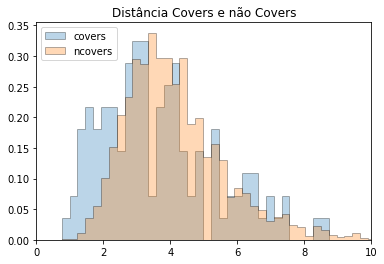

In [325]:
allvalues = np.array(covers+ncovers)
minvalue, maxvalue = np.min(allvalues), np.max(allvalues)

bins = np.linspace(minvalue, maxvalue, 100)

kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=bins, ec="k")

plt.figure()
plt.hist(covers,label='covers', **kwargs)
plt.hist(ncovers,label='ncovers', **kwargs)
plt.legend(loc='upper left')
plt.title('Distância Covers e não Covers')
filename = os.path.join(results_path,"distances_qbh.svg")

plt.xlim([0.0, 10.0])
plt.savefig(filename, bbox_inches='tight')

plt.show()